In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from pyvi import ViTokenizer, ViPosTagger
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from matplotlib import rcParams
from sklearn.preprocessing import FunctionTransformer
import re
from nltk.stem.porter import PorterStemmer
from sklearn.pipeline import Pipeline, make_pipeline
import pickle
import string

## Load Data

In [2]:
data = pd.read_csv("data/vn_news_223_tdlfr.csv")
data.head()

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1


In [3]:
data.shape

(223, 3)

## Data understanding

#### Kiểm tra phân bố các class có chênh lệch hay không (label)

In [4]:
data['label'].value_counts()

0    123
1    100
Name: label, dtype: int64

*Trực quan hóa dữ liệu*

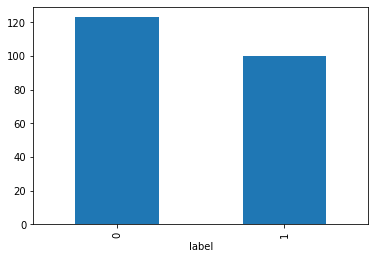

In [5]:
data.groupby(['label'])['text'].count().plot(kind="bar")
plt.show()

#### Kiểm tra dữ liệu bị thiếu hoặc sai dữ liệu

In [6]:
#Xóa dữ liệu bị trùng
data.drop_duplicates(inplace=True , ignore_index=True)
data

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1
...,...,...,...
217,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,dantri.com.vn,0
218,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,dantri.com.vn,0
219,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,dantri.com.vn,0
220,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,dantri.com.vn,0


In [7]:
#Xóa dữ liệu bị thiếu
data=data[~((data['text'].isnull())|
                  (data['domain'].isnull()))]
data

,text,domain,label
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1
...,...,...,...
217,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,dantri.com.vn,0
218,Thưởng 20.000 USD cho đội tuyển cờ vua Việt Na...,dantri.com.vn,0
219,Trường Sơn giành HCV tại giải cờ vua đồng đội ...,dantri.com.vn,0
220,Chuyện về chàng sinh viên Luật - Kiện tướng Lê...,dantri.com.vn,0


#### Các thông tin thống kê của văn bản

- Có bao nhiêu chủ đề cho mỗi tên miền

In [8]:
data.groupby(['domain'])['text'].count()

domain
autoxe.net                  1
baoangiang.com.vn           1
baonuocmy.com               1
binhluan.biz                1
dantri.com.vn              14
doisong.vnexpress.net       2
dulich.vnexpress.net        1
giadinhtiepthi.com          2
giaitri.vnexpress.net       2
haiduong.tintuc.vn          1
https://news.zing.vn        1
kinhdoanh.vnexpress.net     3
laodong.vn                  1
news.zing.vn                6
phapluat.news               3
sohoa.vnexpress.net         1
sorry.vn                    1
suckhoe.vnexpress.net       1
thanhnien.vn                5
thegioitre.vn               2
thethao.tuoitre.vn         10
thoibao.de                  2
thoibao.today               6
tintucqpvn.net              5
tinvn.info                 67
tuoitre.vn                  5
vnexpress.net              73
www.gioitreviet.net         1
www.ipick.vn                2
www.vietgiaitri.com/        1
Name: text, dtype: int64

Trực quan hóa dữ liệu trên

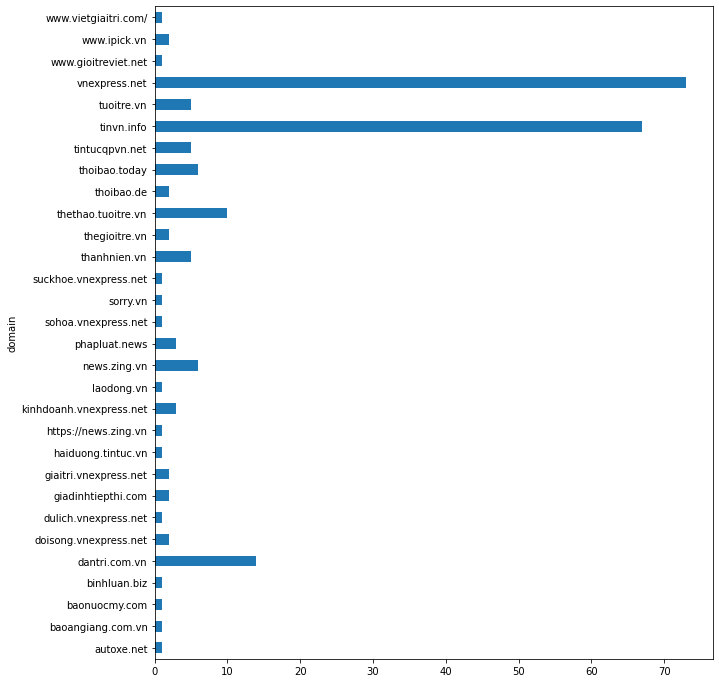

In [9]:
rcParams["figure.figsize"] = 10, 12
data.groupby(['domain'])['text'].count().plot(kind="barh")
plt.show()

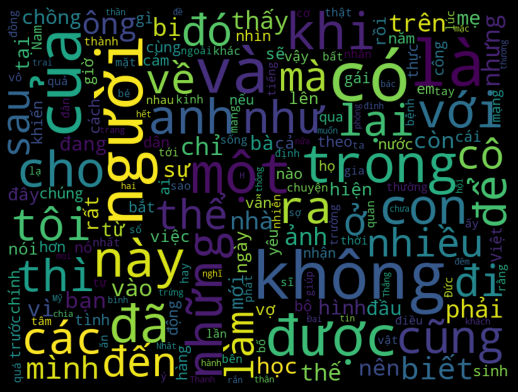

In [10]:
#Đám mây tin giả
fake_data = ' '.join(list(data[data['label']==1]['text']))
fake_data = WordCloud(width= 800, height= 600,
                          max_font_size = 110,
                          collocations = False).generate(fake_data)


plt.figure(figsize=(7,7),facecolor='k')
plt.imshow(fake_data)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

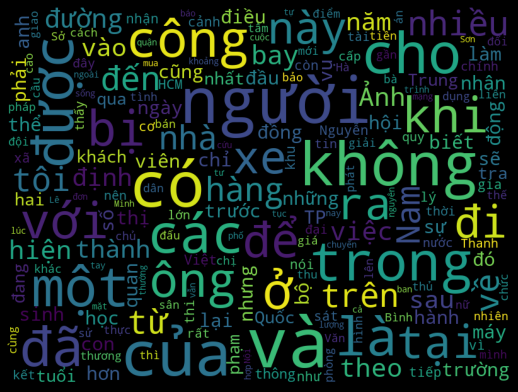

In [11]:
#Đám mây tin thật
real_data = ' '.join(list(data[data['label']==0]['text']))
real_data = WordCloud(width= 800, height= 600,
                          max_font_size = 110,
                          collocations = False).generate(real_data)


plt.figure(figsize=(7,7),facecolor='k')
plt.imshow(real_data)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Train test split

In [12]:
y = data['label']
X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

## Preprocessing

#### Load stopwords
StopWords là những từ xuất hiện trong ngôn ngữ tự nhiên, tuy nhiên lại không mang nhiều ý nghĩa, ví dụ trong tiếng Việt sẽ có các từ như: này, kia, là, ê, ... Ở đây chúng ta dùng file `vietnamese-stopwords-dash.txt` để loại bỏ

In [13]:
with open('data/vietnamese-stopwords.txt', encoding='utf-8') as f:
    lines = f.read()
    
# Danh sách stopword
stopwords = lines.split('\n')
# insert underscore between words
stopwords = [re.sub(r'\s+', '_', word) for word in stopwords]
stopwords[:10]

['a_lô',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_nấy',
 'ai_đó',
 'alô',
 'amen',
 'anh',
 'anh_ấy']

#### Preprocessor

*Tokenize* các từ là thao tác tách các từ có nghĩa ra riêng biệt nhau giúp cho việc học máy tốt hơn.
Thư viện pivy và underthesea hỗ trợ tokenize cho tiếng Việt, nhưng vì thời gian tokenize của underthesea gấp 8 lần pivy, vì vậy chúng ta sẽ dùng pivy.

In [14]:
def text_preprocessor(X):
    ps = PorterStemmer()
    preprocessed_text = []
    for news in X:
        # remove special characters
        news = [word for word in news if word not in string.punctuation]
        news = ''.join(news)
        
        # lower case
        news = news.lower()
        
        # tokenizing
        news = ViTokenizer.tokenize(news)
        
        # remove stopwords and stemming
        temp = news.split()
        news = [ps.stem(word) for word in temp if word not in stopwords]
        news = ' '.join(news)
        
        preprocessed_text.append(news)
        
    return preprocessed_text

#### Make pipeline for preprocessing and vectorizing

**Trích chọn thuộc tính trong đoạn văn bản với TF-IDF**
Mô hình Vector Space Model biểu diễn văn bản thành dạng một vector, các phần tử trong vector có thể biểu diễn mức độ quan trọng của một từ (TF-IDF) hoặc dạng có mặt hoặc vằng mặt của một từ trong đoạn văn bản
- `TF(Term Frequency)`: tần suất xuất hiện của một từ trong đoạn văn bản
- `IDF(Inverse Document Frequency)`: tính toán độ quan trọng của mỗi từ
![image.png](public/image.png)

In [15]:
preprocessing_pipeline = make_pipeline(
    FunctionTransformer(text_preprocessor, validate=False),
    TfidfVectorizer(analyzer='word', min_df=0)
)

#### Calculate and preprocess for X_train

In [16]:
processed_X_train = preprocessing_pipeline.fit_transform(X=X_train)
processed_X_train = processed_X_train.toarray()
processed_X_train.shape

(155, 6890)

*Visualize the vectorizing*

In [17]:
count_df = pd.DataFrame(processed_X_train, 
                        columns=preprocessing_pipeline['tfidfvectorizer'].get_feature_names())
count_df.head()

,001,01,012018,03,05,08,0h,10,100,1000,...,ổn_định,ở_vậi,ủng_hộ,ủy,ủy_ban,ức_chế,ứng,ứng_dụng,ứng_phó,ứng_viên
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.031108,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.048336,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022749,0.000000,0.0,...,0.0,0.048851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Apply preprocessing for X_test

In [18]:
processed_X_test = preprocessing_pipeline.transform(X=X_test)
processed_X_test = processed_X_test.toarray()
processed_X_test.shape

(67, 6890)

#### Export preprocessing to file for deploying

In [19]:
pickle_out = open("models/preprocessor.pkl","wb")
pickle.dump(preprocessing_pipeline, pickle_out)
pickle_out.close()

## Model